# Laboratorium 4 - rekomendacje dla portali informacyjnych

## Przygotowanie

 * pobierz i wypakuj dataset: https://mind201910small.blob.core.windows.net/release/MINDsmall_train.zip
   * więcej możesz poczytać tutaj: https://learn.microsoft.com/en-us/azure/open-datasets/dataset-microsoft-news
 * [opcjonalnie] utwórz wirtualne środowisko:
 `python3 -m venv ./recsyslab4`
 * zainstaluj potrzebne biblioteki:
 `pip install nltk sklearn`

## Część 1. - przygotowanie danych

In [1]:
# importujemy wszystkie potrzebne pakiety
import codecs
import math
import re
from collections import defaultdict # możesz użyć zamiast zwykłego słownika, rozważ wpływ na czas obliczeń
from string import punctuation

import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# możesz użyć do obliczania najbardziej podobnych tekstów zamiast liczenia "na piechotę"
# pamiętaj o dostosowaniu formatu danych
from sklearn.neighbors import NearestNeighbors

import numpy as np

# na potrzeby wizualizacji
import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# definiujemy potrzebne zmienne
PATH = './MINDsmall_train'
STOPWORDS = set(stopwords.words('english'))

In [3]:
# wczytujemy metadane artykułów
def parse_news_entry(entry):
    news_id, category, subcategory, title, abstract = entry.split('\t')[:5]

    return {
        'news_id': news_id,
        'category': category,
        'subcategory': subcategory,
        'title': title,
        'abstract': abstract
    }


def get_news_metadata():
    with codecs.open(f'{PATH}/news.tsv', 'r', 'UTF-8') as f:
        raw = [x for x in f.read().split('\n') if x]
        parsed_entries = [parse_news_entry(entry) for entry in raw]

        return {x['news_id']: x for x in parsed_entries}


news = get_news_metadata()
news_ids = sorted(list(news.keys()))
news_indices = {x[1]: x[0] for x in enumerate(news_ids)}
print(len(news))

51282


In [4]:
def parse_history_entry(entry):
    _id, user_id, _time, history, _impressions = entry.split('\t')
    history = [x for x in history.split() if x]

    return user_id, history


def get_users_history():
    with codecs.open(f'{PATH}/behaviors.tsv', 'r', 'UTF-8') as f:
        lines = [x for x in f.read().split('\n') if x]
        entries = [parse_history_entry(x) for x in lines]

        return dict(entries)


users_history = get_users_history()
print(len(users_history))

50000


## Część 2. - TF-IDF

In [5]:
# normalizujemy teksty na potrzeby dalszego przetwarzania
def preprocess_text(text):
    # zamieniamy wszystkie ciągi białych znaków na pojedyncze spacje
    processed_text = ' '.join(text.split())

    # usuwamy znaki interpunkcyjne
    translator = str.maketrans('', '', punctuation)
    processed_text = processed_text.translate(translator)

    # usuwamy wszystkie liczby
    processed_text = re.sub(r'\d+', '', processed_text)
    
    # podmieniamy wszystkie wielkie litery
    processed_text = processed_text.lower()

    # dzielimy na tokeny
    tokens = processed_text.split()

    # usuwamy stopwords
    tokens = list(filter(lambda token: token not in STOPWORDS, tokens))

    return tokens


def stem_texts(corpus):
    # przetestuj różne stemmery
    stemmer = LancasterStemmer()

    return [[stemmer.stem(word) for word in preprocess_text(text)] for text in corpus]


texts = [news[news_id]['abstract'] for news_id in news_ids]
stemmed_texts = stem_texts(texts)

In [6]:
# porównajmy teksty przed i po przetworzeniu
print(texts[2] + '\n')
print(' '.join(stemmed_texts[2]))

"I think we have a really good team, and a team that can really do some special, good things because that group is very close in there." - Brian Schmetzer

think real good team team real spec good thing group clos bri schmetzer


In [7]:
# tworzymy listę wszystkich słów w korpusie
def get_all_words_sorted(corpus):
    # generujemy posortowaną alfabetycznie listę wszystkich słów (tokenów)
    all_words_set = set([word for text in corpus for word in text])
    
    return sorted(all_words_set)


wordlist = get_all_words_sorted(stemmed_texts)
word_indices = {x[1]: x[0] for x in enumerate(wordlist)}
print(len(wordlist))

37021


In [8]:
# obliczamy liczbę tekstów, w których wystąpiło każde ze słów
# pamiętaj, że jeśli słowo wystąpiło w danym tekście wielokrotnie, to liczymy je tylko raz
def get_document_frequencies(corpus, wordlist):
    # return {word -> count}
    document_frequencies = {word: 0 for word in wordlist}

    for text in corpus:
        for word in set(text):
            document_frequencies[word] += 1
    
    return document_frequencies


document_frequency = get_document_frequencies(stemmed_texts, wordlist)

In [9]:
# obliczamy liczbę wystąpień każdego słowa w każdym tekście
def get_term_frequencies(corpus, news_indices):
    # return {news_id -> {word -> count}}
    term_frequencies = {news_id: defaultdict(int) for news_id in news_indices}

    for news_id, text in zip(news_indices, corpus):
        for word in text:
            term_frequencies[news_id][word] += 1

    return term_frequencies


term_frequency = get_term_frequencies(stemmed_texts, news_indices)

In [10]:
# sprawdźmy wyniki
term_frequency[news_ids[2]]

defaultdict(int,
            {'think': 1,
             'real': 2,
             'good': 2,
             'team': 2,
             'spec': 1,
             'thing': 1,
             'group': 1,
             'clos': 1,
             'bri': 1,
             'schmetzer': 1})

In [11]:
# obliczamy metrykę tf_idf
def calculate_tf_idf(term_frequency, document_frequency, corpus_size):
    # return {news_id -> {word -> tf_idf}}
    tf_idf = {news_id: {} for news_id in term_frequency}

    for news_id, words in term_frequency.items():
        for word in words:
            tf_idf[news_id][word] =\
                term_frequency[news_id][word] * math.log(corpus_size / document_frequency[word])

    return tf_idf


tf_idf = calculate_tf_idf(term_frequency, document_frequency, len(news_ids))

In [12]:
# sprawdźmy wyniki
tf_idf[news_ids[2]]

{'think': 4.358934303449984,
 'real': 7.794316047558208,
 'good': 8.080961144662899,
 'team': 6.054134307726688,
 'spec': 4.4009638356936325,
 'thing': 4.111693200556713,
 'group': 4.260303700008357,
 'clos': 3.7360329567069006,
 'bri': 5.592821664347443,
 'schmetzer': 9.458800731274183}

## Część 3. - Podobieństwo tekstów

In [13]:
# obliczmy odległość między dwoma artykułami
# przetestuj różne metryki odległości i wybierz najlepszą
# zaimplementuj obsługę co najmniej dwóch metryk
def calculate_distance(tf_idf, id1, id2, metric):
    article1 = tf_idf[id1]
    article2 = tf_idf[id2]
    words = set(article1.keys()) | set(article2.keys())
    vector1 = np.array([article1.get(word, 0) for word in words])
    vector2 = np.array([article2.get(word, 0) for word in words])

    if metric == 'cosine': # obsługa metryki cosinusowej
        # najpierw obliczamy iloczyn skalarny
        dot_product = np.dot(vector1, vector2)

        # następnie obliczamy normy wektorów
        norm1 = np.linalg.norm(vector1)
        norm2 = np.linalg.norm(vector2)

        # sprawdzamy, żeby nie dzielić przez zero
        return 1. if norm1 * norm2 == 0. else 1. - dot_product / (norm1 * norm2)
    elif metric == 'euclidean': # obsługa metryki euklidesowej
        return np.linalg.norm(np.subtract(vector1, vector2))
    else:
        raise ValueError(f"Metryka {metric} nie jest obecnie wspierana!")


print("Cosine distance:", calculate_distance(tf_idf, news_ids[2], news_ids[1], metric='cosine'))
print("Euclidean distance:", calculate_distance(tf_idf, news_ids[2], news_ids[1], metric='euclidean'))


Cosine distance: 0.9511464152949101
Euclidean distance: 42.6074265439805


In [14]:
# funkcja pomocnicza do wyświetlania artykułów
def print_news_entry(n_id, corpus):
    print(f'id: {n_id}\n\ttitle: {corpus[n_id]["title"]}\n\ttext: {corpus[n_id]["abstract"]}')


print_news_entry('N42782', news)

id: N42782
	title: Three takeaways from Yankees' ALCS Game 5 victory over the Astros
	text: The Yankees kept hope alive thanks to some impressive starting pitching and a pair of early home runs.


In [15]:
# wyznaczmy k najpodobniejszych tekstów do danego
# pamiętaj o odpowiedniej kolejności sortowania w zależności od wykorzystanej metryki
# pamiętaj, żeby wśród podobnych tekstów nie było danego
def get_k_most_similar_news(tf_idf, n_id, k, metric):
    other_distances = [
        (calculate_distance(tf_idf, n_id, n_id2, metric), n_id2) for n_id2 in tf_idf if n_id != n_id2
    ]
    
    return [item[1] for item in sorted(other_distances)[:k]]


def print_k_most_similar_news(tf_idf, n_id, k, metric, corpus):
    similar = get_k_most_similar_news(tf_idf, n_id, k, metric)
    print_news_entry(n_id, corpus)
    print(f'\n{k} most similar:')

    for s_id in similar:
       print_news_entry(s_id, corpus)


# wypiszmy wyniki dla metryki cosinusowej
print_k_most_similar_news(tf_idf, news_ids[42337], 5, 'cosine', news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

In [16]:
# to samo, ale dla metryki euklidesowej
print_k_most_similar_news(tf_idf, news_ids[42337], 5, 'euclidean', news)

id: N58544
	title: Tiny Electric Car Cost $420,000 To Build
	text: A MAN claims he has created a car that might solve the world's traffic congestion problems. Rick Woodbury from Spokane, Washington USA, is the president, founder and sole employee of 'Commuter Cars.' The carmaker's flagship model is the 2005 super slim two-seater Tango T600, a high-performance electric car that preceded Tesla. Rick told BTV: "I started this company 21 years ago   it was based on an idea that I came up with in 1982." He was inspired by the shocking traffic congestion he had to face on a daily basis. "I used to drive a Porsche from Beverly Hills to Hermosa Beach every day and the traffic was horrendous," explained Rick. What really made Rick think about a solution was the fact that in most of the cars he would see in his commute were occupied by lone drivers. "I noticed that everybody around me was a single occupant in a car, taking up the whole lane," Rick said. Living and working in Los Angeles also hel

## Część 4. - Profile użytkowników

In [17]:
# oblicz średnią z wektorów tf-idf artykułów o zadanych ids
def calculate_average_vector(tf_idf, news_ids: list[str]) -> dict[str, float]:
    average_vector = defaultdict(float)
    counts = defaultdict(int)

    for news_id in news_ids:
        for word, value in tf_idf[news_id].items():
            average_vector[word] += value
            counts[word] += 1

    for word in average_vector:
        average_vector[word] /= counts[word]

    return average_vector


# wykorzystaj powyższą funkcję, aby policzyć wektor każdego użytkownika
def calculate_users_vectors(tf_idf, users_history) -> dict[str, dict[str, float]]:
    users_vectors = {}

    for user_id, user_history in users_history.items():
        users_vectors[user_id] = calculate_average_vector(tf_idf, user_history)
    
    return users_vectors


user_vectors = calculate_users_vectors(tf_idf, users_history)

In [18]:
# przykładowi testowi użytkownicy
test_users = 'U53231', 'U89744', 'U10045', 'U92486', 'U70879'

# sprawdź wyliczony profil dla przykładowego użytkownika
print(sorted([(k, v) for k, v in user_vectors[test_users[0]].items() if v], key=lambda x: -x[1]))

[('diaz', 27.575405495250582), ('hailston', 20.303895823668256), ('tornado', 17.864237892516957), ('noa', 17.531307101428474), ('ef', 14.887795421463835), ('ditch', 14.697175061855186), ('mcconnell', 14.415017865335374), ('saud', 13.787702747625291), ('hudson', 13.712222091659598), ('hors', 13.372424018068802), ('blood', 12.85250896919495), ('marc', 12.646613030690066), ('reliev', 12.499950484518966), ('licens', 12.217793287999156), ('shelt', 12.148820935856817), ('complaint', 11.806905339569537), ('impeach', 11.729173939136889), ('smok', 11.539842554320492), ('chas', 11.175199440732582), ('facil', 11.164809806978376), ('ventur', 10.892364230906944), ('nitc', 10.845095092394073), ('livewir', 10.845095092394073), ('cater', 10.845095092394073), ('reatt', 10.845095092394073), ('phaeton', 10.845095092394073), ('culiacán', 10.845095092394073), ('mcconnells', 10.845095092394073), ('shantnaz', 10.845095092394073), ('nightf', 10.845095092394073), ('thrillseeking', 10.845095092394073), ('guilin

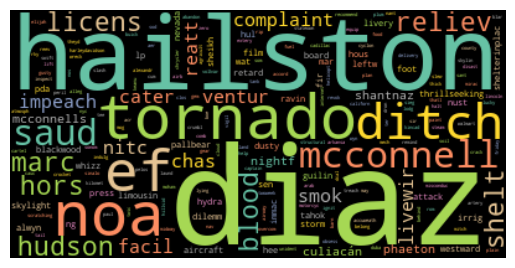

In [19]:
# skorzystajmy ze znanej już biblioteki, by to lepiej zwizualizować
def plot_vector(tf_idf_vector):
    wordcloud = WordCloud(random_state=42, background_color='black', colormap='Set2')
    wordcloud.generate_from_frequencies(frequencies=tf_idf_vector)

    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()


plot_vector(user_vectors[test_users[0]])

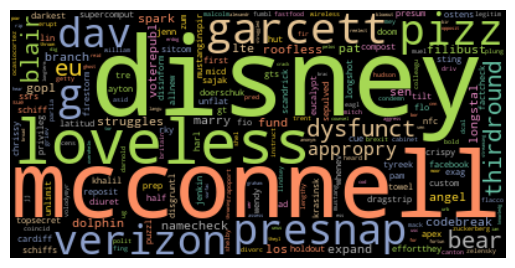

In [20]:
# zobaczmy też wordcloud dla innego użytkownika
plot_vector(user_vectors[test_users[2]])

## Część 5. - Rekomendacje dla użytkowników

In [21]:
# wykorzystując wektory treści i profile użytkowników, wygeneruj listę k artykułów najlepiej
# dopasowanych do użytkownika; pamiętaj o odsianiu artykułów, które użytkownik już kliknął
def recommend(tf_idf, user_id, news, users_history, k, metric):
    user_vector = calculate_average_vector(tf_idf, users_history[user_id])
    recommendations = []

    for news_id in news:
        if news_id not in users_history[user_id]:
            # tworzę "tymczasowy" słownik, żeby porównać wektor artykułu z wektorem użytkownika
            temp = {news_id: tf_idf[news_id], user_id: user_vector}
            
            distance = calculate_distance(temp, news_id, user_id, metric)
            recommendations.append((distance, news_id))
    
    return [item[1] for item in sorted(recommendations)[:k]]


# dla wybranego użytkownika, korzystając z już zaimplementowanych funkcji,
# pokaż jego historię, profil (wordcloud) i rekomendację
print(f"Historia użytkownika '{test_users[1]}':")

for news_id in users_history[test_users[1]]:
    print_news_entry(news_id, news)

Historia użytkownika 'U89744':
id: N24422
	title: Lamar Jackson makes NFL history with huge day in win over Bengals
	text: 
id: N25287
	title: Steve Kerr: Steph Curry is 'at his peak physically, mentally'
	text: 
id: N39121
	title: Celtics, Zion remain sizzling to start preseason
	text: Preseason numbers often mean almost nothing. Rotations are unusual, starters rarely play much, and few if any teams are putting a premium on winning games. As such, it's tough to glean much from exhibition stats. But what the Boston Celtics and New Orleans rookie Zion Williamson   the No. 1 pick in this year's draft   have been doing so far in the preseason certainly stands out. The Celtics are 3-0 after beating Cleveland on Sunday   and have...
id: N41777
	title: Kate Upton was so fired up after the Astros' big defensive play
	text: The Houston Astros made a great defensive play to keep Game 2 of the ALCS tied in the sixth inning, and perhaps nobody was more excited about it than Kate Upton.
id: N58226

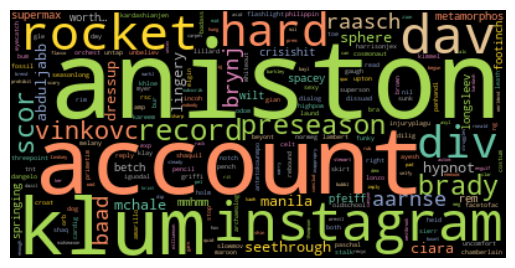

In [22]:
# profil użytkownika
plot_vector(user_vectors[test_users[1]])

In [23]:
# rekomendacja dla użytkownika
recommendations = recommend(tf_idf, test_users[1], news, users_history, k=5, metric='cosine')
print("Rekomendowane 5 artykułów:")

for news_id in recommendations:
    print_news_entry(news_id, news)

Rekomendowane 5 artykułów:
id: N27232
	title: See who broke records on Instagram
	text: Jennifer Aniston broke the record and crashed the app when she joined Instagram. Here are some other notable records.
id: N25699
	title: This Post Proves Jennifer Aniston Is Already an Instagram Expert
	text: Jennifer Aniston Proves She's an Instagram Expert
id: N36132
	title: Finally! Jennifer Aniston Joins Instagram With Brand-New 'Friends' Cast Photo
	text: Finally! Jennifer Aniston Joins Instagram With Brand-New 'Friends' Cast Photo
id: N42322
	title: 25 times someone 'broke the internet' in the last decade
	text: Jennifer Aniston 'broke the internet' when she joined Instagram this year. But it's not just celebrities who have sent social media into a spin. Here's the top viral moments from the past decade.
id: N12112
	title: Harden scores 39 points as Rockets beat Pelicans 122-116
	text: NEW ORLEANS (AP)   As usual, scoring comes in concentrated bursts for James Harden. Harden scored 19 of his 3

In [24]:
# to samo, ale dla metryki euklidesowej
recommendations = recommend(tf_idf, test_users[1], news, users_history, k=5, metric='euclidean')
print("Rekomendowane 5 artykułów:")

for news_id in recommendations:
    print_news_entry(news_id, news)

Rekomendowane 5 artykułów:
id: N27232
	title: See who broke records on Instagram
	text: Jennifer Aniston broke the record and crashed the app when she joined Instagram. Here are some other notable records.
id: N42322
	title: 25 times someone 'broke the internet' in the last decade
	text: Jennifer Aniston 'broke the internet' when she joined Instagram this year. But it's not just celebrities who have sent social media into a spin. Here's the top viral moments from the past decade.
id: N25699
	title: This Post Proves Jennifer Aniston Is Already an Instagram Expert
	text: Jennifer Aniston Proves She's an Instagram Expert
id: N36132
	title: Finally! Jennifer Aniston Joins Instagram With Brand-New 'Friends' Cast Photo
	text: Finally! Jennifer Aniston Joins Instagram With Brand-New 'Friends' Cast Photo
id: N40344
	title: Felicity Huffman begins prison sentence and more ICYMI news
	text: Felicity Huffman begins prison sentence, the Chrisleys sue a tax man, Jennifer Aniston breaks Instagram an

## Część 6. - Ocena jakości

In [25]:
# jaccard index to metryka podobieństwa zbiorów, lekko ją zmodyfikujemy:
# - przecięcie wektorów to minimum po każdej współrzędnej
# - unia wektorów to maksimum po każdej współrzędnej
# - jaccard index to iloraz sum tych dwóch wartości
def jaccard(v1, v2):
    words = set(v1.keys()) | set(v2.keys())
    intersection = [min(v1[word], v2[word]) for word in words]
    union = [max(v1[word], v2[word]) for word in words]

    return sum(intersection) / sum(union)

In [26]:
# dla każdego użytkownika wygeneruj k-elementową rekomendację
# policz jaccard index między wektorem użytkownika a średnim wektorem elementów z rekomendacji
# porównaj wyniki dla dwóch różnych k i dwóch różnych metryk podobieństwa
for k in [5, 10]:
    for metric in ['cosine', 'euclidean']:
        print(f"Wyniki dla k={k}, metryka: {metric}")

        for user_id in test_users:
            user_vector = calculate_average_vector(tf_idf, users_history[user_id])
            recommendations = recommend(tf_idf, user_id, news, users_history, k, metric)
            recommendation_vector = calculate_average_vector(tf_idf, recommendations)
            jaccard_index = jaccard(user_vector, recommendation_vector)
            print(f"Wartość jaccard index dla użytkownika '{user_id}': {jaccard_index:.4f}")

        if metric == 'cosine':
            print()

    if k == 5:
        print('\n' + '-' * 54 + '\n')

Wyniki dla k=5, metryka: cosine
Wartość jaccard index dla użytkownika 'U53231': 0.1169
Wartość jaccard index dla użytkownika 'U89744': 0.0449
Wartość jaccard index dla użytkownika 'U10045': 0.1127
Wartość jaccard index dla użytkownika 'U92486': 0.0779
Wartość jaccard index dla użytkownika 'U70879': 0.0599

Wyniki dla k=5, metryka: euclidean
Wartość jaccard index dla użytkownika 'U53231': 0.0754
Wartość jaccard index dla użytkownika 'U89744': 0.0258
Wartość jaccard index dla użytkownika 'U10045': 0.0785
Wartość jaccard index dla użytkownika 'U92486': 0.0741
Wartość jaccard index dla użytkownika 'U70879': 0.0541

------------------------------------------------------

Wyniki dla k=10, metryka: cosine
Wartość jaccard index dla użytkownika 'U53231': 0.1543
Wartość jaccard index dla użytkownika 'U89744': 0.0804
Wartość jaccard index dla użytkownika 'U10045': 0.1725
Wartość jaccard index dla użytkownika 'U92486': 0.1085
Wartość jaccard index dla użytkownika 'U70879': 0.0900

Wyniki dla k=10,